# Lab 07: Genetic Algorithms

## Total: 50 points

In this lab, you'll explore the fundamentals of genetic algorithms by implementing core operations like selection, crossover, and mutation. We give you the initialization code and fitness function so you can focus the different ways to implement core operations.

## General Instructions

- Carefully read through the commented helper functions.
- Implement the missing functions where marked with `pass`.
- This lab is VERY open ended! There isn't one way to do this. Implement the strategies or verisons that interest you!
- **We have provided suggested parameters to pass into the unimplemented functions, but depending on the methods you pick, the parameters might change or you will need additional ones. Make sure to edit the parameter list for methods and strategies you use!!** 

In [1]:
import random
import matplotlib.pyplot as plt
import time

In [2]:
# Problem Constants
NUM_PEOPLE = 5
SHIFTS_PER_DAY = 3
DAYS_PER_WEEK = 7
SHIFTS_PER_WEEK = SHIFTS_PER_DAY * DAYS_PER_WEEK # 21

In [3]:
# GA Parameters
POPULATION_SIZE = 100       # Number of schedules in each generation
GENERATIONS = 150           # Number of generations to run
MUTATION_RATE = 0.02        # Probability of a single bit flip mutation
CROSSOVER_RATE = 0.7        # Probability that crossover occurs between two parents
HARD_PENALTY = -2           # Penalty per violated hard constraint
SOFT_PENALTY = -1           # Penalty per violated soft constraint

# Helper Functions

In [4]:
## Helper Functions
def get_shift_details(shift_index):
    """
    Calculates day (0-6) and shift type (0=M, 1=A, 2=N) from shift index (0-20).

    Args:
        shift_index (int): The shift index (0-20)

    Returns:
        day (int): The day of the week (0-6)
        shift_type (int): The shift type (0=M, 1=A, 2=N)
    """
    if not (0 <= shift_index < SHIFTS_PER_WEEK):
        raise ValueError(f"shift_index {shift_index} out of range [0, {SHIFTS_PER_WEEK-1}]")
    day = shift_index // SHIFTS_PER_DAY
    shift_type = shift_index % SHIFTS_PER_DAY
    return day, shift_type

def print_schedule(schedule, fitness):
    """
    Prints the schedule in a readable format.

    Args:
        schedule (list): The schedule to print
        fitness (float): The fitness score of the schedule
    """
    print(f"\nSchedule (Fitness: {fitness:.2f}):")
    days = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
    shifts = ["M", "A", "N"]
    header = "      " + " | ".join([days[d] for d in range(DAYS_PER_WEEK)])
    print(header)
    subheader = "      " + " ".join([f"{s}" for _ in days for s in shifts])
    print(subheader)
    print("      " + "-" * (len(subheader)-1))
    for person_idx, person_schedule in enumerate(schedule):
        schedule_str = ""
        for i in range(SHIFTS_PER_WEEK):
             schedule_str += str(person_schedule[i])
             if (i + 1) % SHIFTS_PER_DAY == 0 and i < SHIFTS_PER_WEEK - 1:
                 schedule_str += " " # Add space between days
        print(f"ATC {person_idx+1}: {schedule_str}")
    print("-" * (len(subheader) + 5))

def plot_fitness(fitness_history):
    """
    Plots the best and average fitness score per generation.

    Args:
        fitness_history (list): A list of fitness scores for each generation

    Returns:
        None
    """
    plt.figure(figsize=(12, 6))
    generations = range(1, len(fitness_history) + 1)
    plt.plot(generations, fitness_history, marker='o', linestyle='-', label='Best Fitness')
    plt.title('GA Fitness Progression for ATC Scheduling')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Score (Higher is Better)')
    # Set y-limit to start slightly below the minimum fitness achieved or a reasonable lower bound
    min_fitness = min(fitness_history)
    plt.ylim(bottom=min(min_fitness - 5, -50)) # Adjust y-axis floor
    plt.legend()
    plt.grid(True)
    plt.show()

## Initialization

Helper code to create the initial population. Make sure you understand how we have chosen to represent the individual and population!

In [5]:
# Init GA
def generate_initial_representation(num_people, shifts_per_week):
  """
  Creates a single random schedule representation (chromosome).
  Each person gets a list of 0s and 1s for the week's shifts.

  Args:
    num_people (int): The number of people in the schedule.
    shifts_per_week (int): The number of shifts per week.

  Returns:
    schedule (list): A list of lists, where each inner list represents a person's schedule for the week.
  """
  schedule = []
  for _ in range(num_people):
    person_schedule = [random.choice([0, 1]) for _ in range(shifts_per_week)]
    schedule.append(person_schedule)
  return schedule

def generate_population(population_size, num_people, shifts_per_week):
  """ Creates the initial population of random schedules. """
  return [generate_initial_representation(num_people, shifts_per_week)
          for _ in range(population_size)]

## Fitness Function

Evaluate how close a candidate is to the target solution. Note how hard versus soft constraints are handled.

In [6]:
def evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day):
    """ 
    Calculates the fitness of a single schedule based on constraints. 

    Args:
        schedule (list): The schedule to evaluate
        num_people (int): The number of people in the schedule
        shifts_per_week (int): The number of shifts per week
        shifts_per_day (int): The number of shifts per day

    Returns:
        fitness (float): The fitness score of the schedule
    """
    fitness = 0 # Start with perfect fitness, subtract penalties

    # Hard Constraint Checks

    # 1. Minimum controllers per shift
    min_controllers = {0: 1, 1: 2, 2: 1} # M:1, A:2, N:1
    shift_violations = 0
    for shift_idx in range(shifts_per_week):
        _, shift_type = get_shift_details(shift_idx)

        # Calculate number of controllers on this shift
        controllers_on_shift = sum(schedule[p][shift_idx] for p in range(num_people))
        required = min_controllers[shift_type]

        # Penalize for each missing controller
        if controllers_on_shift < required:
            fitness += HARD_PENALTY * (required - controllers_on_shift)
            shift_violations += (required - controllers_on_shift)

    # 2. Rest periods
    rest_violations = 0
    for p in range(num_people):
        for shift_idx in range(shifts_per_week):
            if schedule[p][shift_idx] == 1: # If person p works this shift
                _, shift_type = get_shift_details(shift_idx)

                # a) Rest after Morning (0) or Afternoon (1)
                if shift_type in [0, 1]:
                    next_shift_idx = shift_idx + 1
                    # Check boundary: ensure next shift is within the week
                    if next_shift_idx < shifts_per_week and schedule[p][next_shift_idx] == 1:
                         fitness += HARD_PENALTY # Violation: Working the very next shift
                         rest_violations += 1

                # b) Rest after Night (2)
                elif shift_type == 2:
                    # Check the next 3 shifts (full day)
                    violation_found_for_night_shift = False
                    for i in range(1, shifts_per_day + 1):
                        next_shift_idx = shift_idx + i
                        # Check boundary: ensure check stays within the week
                        if next_shift_idx < shifts_per_week and schedule[p][next_shift_idx] == 1:
                            if not violation_found_for_night_shift: # Only penalize once per night shift violation
                                fitness += HARD_PENALTY
                                rest_violations += 1
                                violation_found_for_night_shift = True
                            # No need to check further shifts for *this* night shift once violation is found

    # Soft Constraint Checks

    # 1. Excess controllers in tower
    excess_violations = 0
    for shift_idx in range(shifts_per_week):
        _, shift_type = get_shift_details(shift_idx)
        controllers_on_shift = sum(schedule[p][shift_idx] for p in range(num_people))
        required = min_controllers[shift_type]
        if controllers_on_shift > required:
            excess = controllers_on_shift - required
            fitness += SOFT_PENALTY * excess # Penalize for each extra controller
            excess_violations += excess

    # A fitness of 0 means no constraints were violated. Higher (less negative) is better.
    # You could also return the counts of violations for analysis if needed:
    # return fitness, shift_violations, rest_violations, excess_violations
    return fitness

## Q1.1 Parent Selection (4 points)

In this step, pick the parents chosen for crossover. Recall there are lots of different ways this can fit together with the crossover step. It's up to you on which method you pick.

In [7]:
def parent_selection(population, fitness_scores):
    """
    Selects the parents chosen for crossover using the roulette wheel method. 

    Args:
        population(list): The population to choose from
        fitness_scores (list): The fitness score of each member in the population

    Returns:
        selected_parents (list): The selected parents
    """
    # since fitness values are negative, convert them to positive values where higher is better
    adjusted_fitness = [1 / (1 + abs(score)) for score in fitness_scores]
    
    total_fitness = sum(adjusted_fitness)
    probabilities = [fit / total_fitness for fit in adjusted_fitness]

    parents = random.choices(population, k=50, weights=probabilities)
    return parents

## Q1.2 Crossover (4 points)

In this step, you combine two (or more) parent chromosomes to produce an offspring (or more). Recall that you can use the CROSSOVER_RATE parameter.

In [8]:
import copy

def crossover(parent_1, parent_2, num_people, shifts_per_week, crossover_rate):
    """
    Combines parents chromosomes to produce offspring using uniform crossover.

    Args:
        parent_1 (list): One parent (schedule) in the crossover
        parent_2 (list): The other parent in the crossover
        num_people (int): Number of people scheduled
        shifts_per_week (int): Number of shifts per week
        crossover_rate (float): Probability that crossover occurs between two parents

    Returns:
        new_parent_1 (list): The new parent resulting from crossover
        new_parent_2 (list): The new parent resulting from crossover
    """
    new_parent_1 = copy.deepcopy(parent_1)
    new_parent_2 = copy.deepcopy(parent_2)
    
    for person in range(num_people):
        for shift in range(shifts_per_week):
            if random.random() < crossover_rate:
                temp_p1 = parent_1[person][shift]
                parent_1[person][shift] = parent_2[person][shift]
                parent_2[person][shift] = temp_p1    
    
    return new_parent_1, new_parent_2


## Q1.3 Mutation (4 points)

Add random mutations to chromosomes to maintain genetic diversity. You'll implement a function that randomly changes characters in the chromosome string. Recall that you can use the MUTATION_RATE parameter.

In [ ]:
def mutate(schedule, mutation_rate, num_people, shifts_per_week):
    """
    Adds mutations to the schedule by performing bit flips.

    Args:
        schedule (list): The schedule to mutate
        num_people (int): Number of people scheduled
        shifts_per_week (int): Number of shifts per week
        mutation_rate (float): Probability that mutation occurs

    Returns:
        new_schedule (list): The new schedule resulting from mutation
    """
    new_schedule = copy.deepcopy(schedule)

    for person in range(num_people):
        for shift in range(shifts_per_week):
            if random.random() < mutation_rate:
                new_schedule[person][shift] = new_schedule[person][shift]^1
    return new_schedule

## Q1.4 Selection (4 points)

You will implement a method for selecting parent chromosomes based on their fitness scores. The better the fitness, the higher the chance of selection.

In [10]:
def select_survivors(population, offspring_population, population_size, num_people, shifts_per_week, shifts_per_day, days_per_week):
    """
    Selects survivors who will be the parents for the next generation using steady state selection.


    Args:
        population(list): The original population
        offspring_population (list): The offspring created from the selected parents of og. pop.
        population_size (int): The size that each population is maintained at
        num_people (int): The number of people in the schedule
        shifts_per_week (int): The number of shifts per week
        shifts_per_day (int): The number of shifts per day
        days_per_week (int): The number of days per week 

    Returns:
        survivors (list): The new parents
    """

    everyone = population + offspring_population

    # pair every schedule w/ fitness score
    scores = [
        (schedule, evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day))
        for schedule in everyone
    ]

    # sort by fitness
    scores.sort(key=lambda x: x[1], reverse=True)

    # choose individuals with top scores up to population size
    survivors = [schedule for schedule, _ in scores[:population_size]]

    return survivors

## Q1.5 Putting It All Together (4 points)

Finally, integrate all components into a loop to simulate multiple generations of evolution.

In [15]:
def genetic_algorithm(population_size, num_people, shifts_per_week, shifts_per_day, days_per_week,
                      generations, mutation_rate, crossover_rate):
    """
    Runs a genetic algorithm for a specified number of generations to optimize the schedule

    Args:
    population_size (int): The size that each population is maintained at
    num_people (int): The number of people in the schedule
    shifts_per_week (int): The number of shifts per week
    shifts_per_day (int): The number of shifts per day
    days_per_week (int): The number of days per week 
    generations (int): The number of generations the algorithm will create
    mutation_rate (float): Probability that mutation occurs
    crossover_rate (float): Probability that crossover occurs
    
    Returns:
        best_schedule (list): The best schedule generated
        best_fitness (float): The fitness of the best schedule
        history (list): The best fitness of each generation
        avg_history (list): The average of all fitnesses in each generation
    """
    
    best_schedule = None 
    best_fitness = None
    history = []
    avg_history = []

    # generate the initial population
    population = generate_population(population_size, num_people, shifts_per_week)
    
    for gen in range(generations):
        # find the fitness scores of the current population
        fitness_scores = [evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day) for schedule in population]
        best_fitness_curr = max(fitness_scores)

        # see if best fitness of this gen. is greater than overall best
        if best_fitness is None or best_fitness_curr > best_fitness:
            best_fitness = best_fitness_curr
            best_schedule = copy.deepcopy(population[fitness_scores.index(best_fitness_curr)])
        
        # add this generations best and average fitness to history
        history.append(best_fitness_curr)
        avg_history.append(sum(fitness_scores)/len(fitness_scores))

        # select parents
        parents = parent_selection(population, fitness_scores)

        # crossover
        offspring = []
        for _ in range(population_size // 2):
            parent_1 = random.choice(parents)
            parent_2 = random.choice(parents)
            child1, child2 = crossover(parent_1, parent_2, num_people, shifts_per_week, crossover_rate)
            offspring.extend([child1, child2])

        # mutate
        mutated = [mutate(schedule, mutation_rate, num_people, shifts_per_week) for schedule in offspring]

        # select survivors
        population = select_survivors(population, mutated, population_size, num_people, shifts_per_week, shifts_per_day, days_per_week)

    return best_schedule, best_fitness, history, avg_history

# Main

Run the genetic algorithm and plot the fitness scores.


      Best Schedule Found

Schedule (Fitness: 0.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 010 000 000 010 010 010 101
ATC 2: 101 000 010 001 000 000 010
ATC 3: 010 101 000 100 101 000 000
ATC 4: 000 010 010 010 010 010 010
ATC 5: 000 010 101 000 000 101 000
----------------------------------------------------


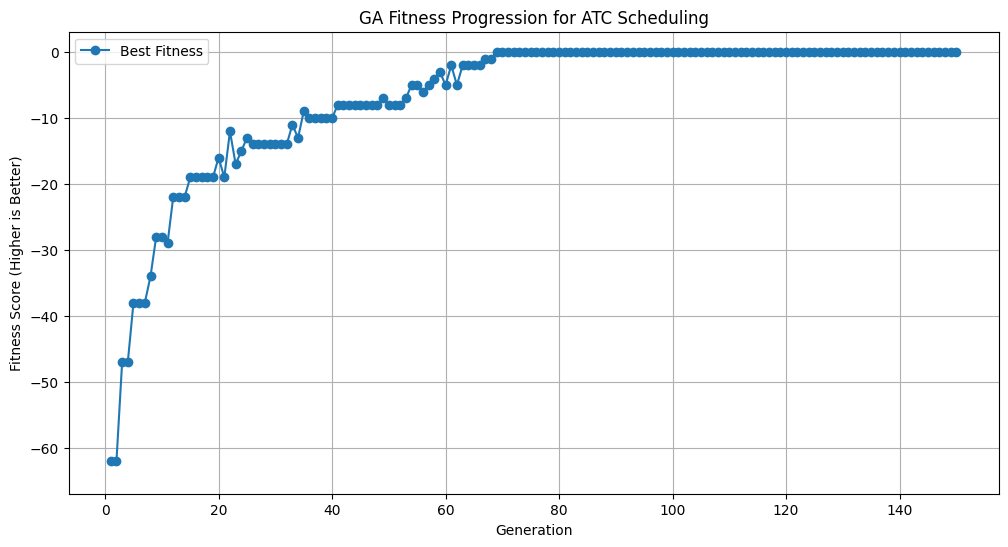

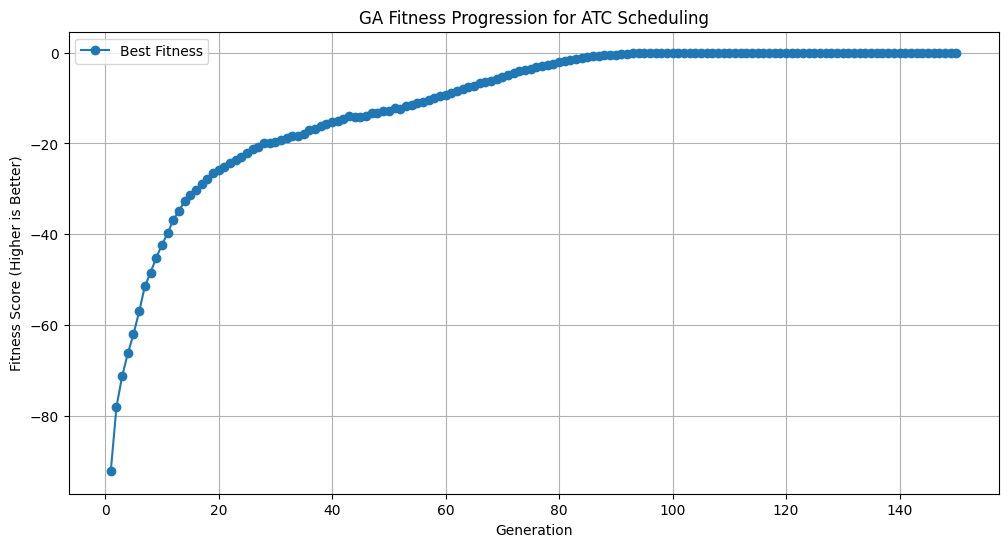

In [16]:
best_schedule, best_fitness, history, avg_history = genetic_algorithm(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
    ) # CHECK THE PARAMETERS!!!

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    # Explain and show the plot
    print("\n" + "="*30)
    print("      Fitness Plot Explanation")
    print("="*30)
    print("The plot shows the fitness score evolution over generations:")
    print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
    print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
    print("Ideally, both lines should trend upwards (towards 0 or positive values).")
    print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history)
plot_fitness(avg_history)

# Q2 Exploring the Solution Space (5 points)

Now that you've written a base genetic algorithm, let's see what additional information you can learn about this problem. Every air traffic controller gets paid the same amount regardless of how many shifts they work. Management wants to find the minimum number of air traffic controllers they need without creating ANY constraint violations.

a. Using your genetic algorithm solver, find the minimum number of air traffic controllers needed.

b. Describe how you came up with your answer to part A and how confident you are in that answer.

# Solution 2

a. I found that 5 was the minimum number of air traffic controller needed  
b. I ran the algorithm many times (like 40, that's a lot ok?) and was able to get a fitness score of 0 with 5 people, but never with any less people. Lowkey it may be possible with less people but idk.

In [25]:
min_people = None
for i in range(25):
    for num_people in range(0, 7):
        best_schedule, best_fitness, history, avg_history = genetic_algorithm(
            population_size=POPULATION_SIZE,
            num_people=num_people,
            shifts_per_week=SHIFTS_PER_WEEK,
            shifts_per_day=SHIFTS_PER_DAY,
            days_per_week=DAYS_PER_WEEK,
            generations=GENERATIONS,
            mutation_rate=MUTATION_RATE,
            crossover_rate=CROSSOVER_RATE,
        )
        if best_fitness == 0:
            if min_people is None:
                min_people = num_people
print(f"min number of people needed: {min_people}")

min number of people needed: 5


# Q3 Tweaking the Parameters (10 points)

Now that you've written a base genetic algorithm, let's see if you can improve the performance by tweaking the parameters. Pick one of the GA Parameters and create a plot showing the results at different values.

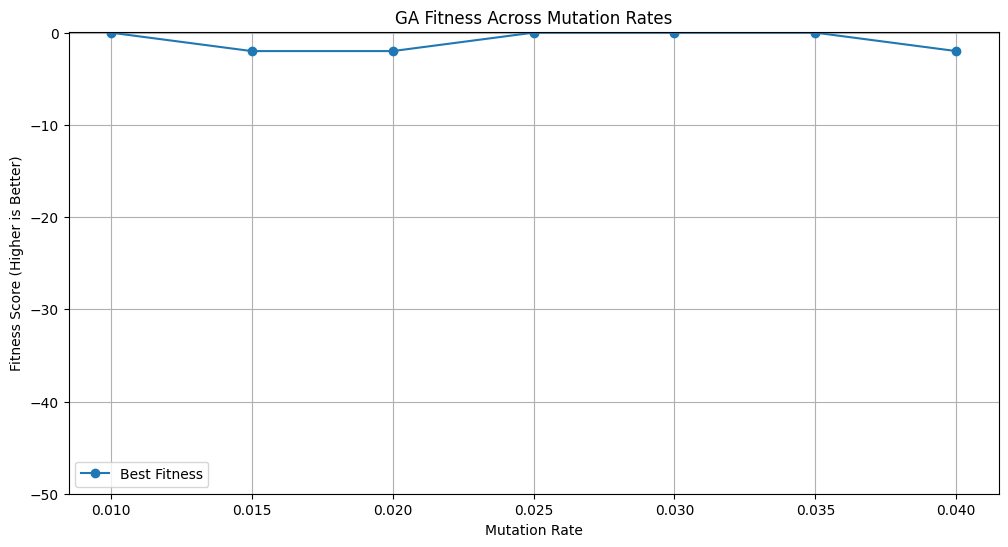

In [39]:
# best_schedule, best_fitness, history, avg_history = genetic_algorithm(
#         population_size=POPULATION_SIZE, # parameter you could pick to sweep 
#         num_people=NUM_PEOPLE,
#         shifts_per_week=SHIFTS_PER_WEEK,
#         shifts_per_day=SHIFTS_PER_DAY,
#         days_per_week=DAYS_PER_WEEK,
#         generations=GENERATIONS,
#         mutation_rate=MUTATION_RATE, # parameter you could pick to sweep 
#         crossover_rate=CROSSOVER_RATE, # parameter you could pick to sweep 
#     )  # CHECK THE PARAMETERS!!!


# CHANGE THIS CODE BELOW SO THAT IT PLOTS THE PARAMETER THAT GETS SWEEPED

mutation_rates = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
sweep_results = []

for rate in mutation_rates:
    best_schedule, best_fitness, history, avg_history = genetic_algorithm(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=rate,
        crossover_rate=CROSSOVER_RATE,
    )
    sweep_results.append(best_fitness)


plt.figure(figsize=(12, 6))
plt.plot(mutation_rates, sweep_results, marker='o', linestyle='-', label='Best Fitness')
plt.title('GA Fitness Across Mutation Rates')
plt.xlabel('Mutation Rate')
plt.ylabel('Fitness Score (Higher is Better)')
# Set y-limit to start slightly below the minimum fitness achieved or a reasonable lower bound
min_fitness = min(sweep_results)
plt.ylim(bottom=min(min_fitness - 5, -50)) # Adjust y-axis floor
plt.legend()
plt.grid(True)
plt.show()


# print("\n" + "="*30)
# print("      Best Schedule Found")
# print("="*30)
# if best_schedule:
#     # Evaluate the final best schedule again to be certain of its fitness score
#     final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
#     print_schedule(best_schedule, final_check_fitness)
#     if abs(final_check_fitness - best_fitness) > 0.01:
#             print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
# else:
#     print("\nNo suitable schedule found (best_schedule is None).")
#     # Explain and show the plot
#     print("\n" + "="*30)
#     print("      Fitness Plot Explanation")
#     print("="*30)
#     print("The plot shows the fitness score evolution over generations:")
#     print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
#     print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
#     print("Ideally, both lines should trend upwards (towards 0 or positive values).")
#     print("The gap between average and best fitness indicates population diversity.")

### Interpret

- What parameter did you pick?

- What was optimal value for that parameter and why?

- Is there another parameter do you think that tweaking it's value will improve the results and why?

# Solution 3
I picked mutation rate.  
The optimal value was between around 0.03. I started by sweeping from 0.1 to 0.9 and found that the fitness dropped dramatically when the mutation rate was above 0.1, so I tested a smaller increment -- 0.01-0.05. I think this means that the crossover and selection are already doing a good job at adding randomness and selecting the best results and having a higher mutation rate would actually introduce worse results.  
I think tweaking the population size would improve the results because there are more chances for favorable results to appear.  

## Q4 Changing Core Operations (15 points)

Finally, we are going to explore other methods for selection, crossover, and mutation. Choose your parent selection, mutation, crossover, or selection function and rewrite it to use a different method. Then, rerun the genetic algorithm and compare the results. Display the comparisons in a graph and interpret the results. You will do this twice; you can pick two different functions or pick the same function and come up with two different versions of it.

Completely optional, but if you are look for some inspiration this paper outlines the success of different kind of selection schemes: [A Comparative Analysis of Selection Schemes
Used in Genetic Algorithms](https://www.cse.unr.edu/~sushil/class/gas/papers/Select.pdf)

- Step/Method you are replacing: steady state selection

- Step/Method you are replacing it with: generational selection

- Interpret the results of this replacement: The results of this replacement are significantly worse -- it was only able to get a score of -24 as opposed to the original which got the optimal score of 0. This makes sense because steady state selection is always picking the best results of both the parents and offspring to become the next generation, while generational selection just takes the offspring without considering fitness.


      Best Schedule Found

Schedule (Fitness: -24.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 000 100 010 100 000 010 000
ATC 2: 010 110 010 001 000 101 000
ATC 3: 000 010 100 000 011 010 111
ATC 4: 010 100 100 000 010 000 000
ATC 5: 101 000 000 000 100 001 000
----------------------------------------------------


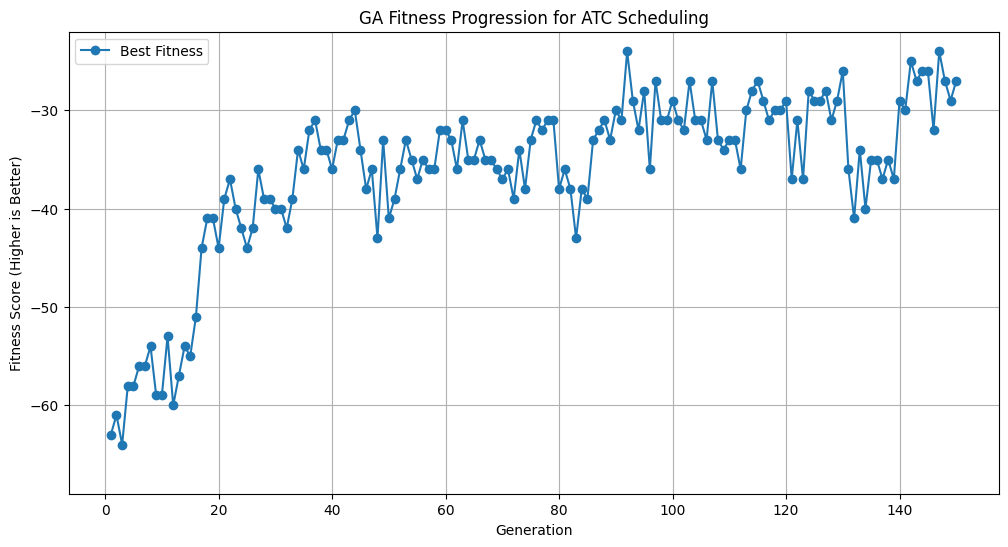

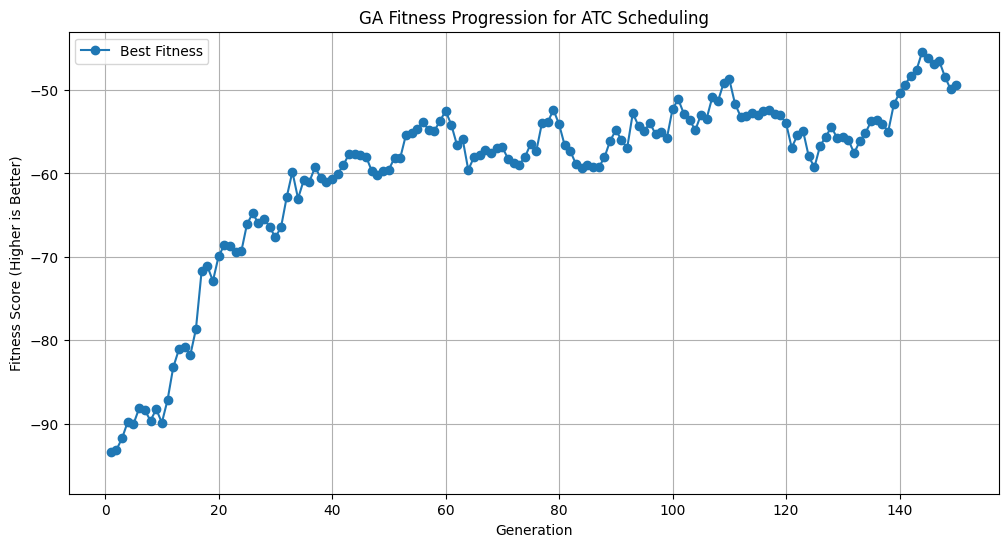

In [41]:
def select_survivors_2(population, offspring_population, population_size, num_people, shifts_per_week, shifts_per_day, days_per_week):
    """
    Selects survivors who will be the parents for the next generation using generational selection.


    Args:
        population(list): The original population
        offspring_population (list): The offspring created from the selected parents of og. pop.
        population_size (int): The size that each population is maintained at
        num_people (int): The number of people in the schedule
        shifts_per_week (int): The number of shifts per week
        shifts_per_day (int): The number of shifts per day
        days_per_week (int): The number of days per week 

    Returns:
        survivors (list): The new parents
    """

    return offspring_population[0:population_size]

def genetic_algorithm_2(population_size, num_people, shifts_per_week, shifts_per_day, days_per_week,
                      generations, mutation_rate, crossover_rate):
    """
    Runs a genetic algorithm for a specified number of generations to optimize the schedule

    Args:
    population_size (int): The size that each population is maintained at
    num_people (int): The number of people in the schedule
    shifts_per_week (int): The number of shifts per week
    shifts_per_day (int): The number of shifts per day
    days_per_week (int): The number of days per week 
    generations (int): The number of generations the algorithm will create
    mutation_rate (float): Probability that mutation occurs
    crossover_rate (float): Probability that crossover occurs
    
    Returns:
        best_schedule (list): The best schedule generated
        best_fitness (float): The fitness of the best schedule
        history (list): The best fitness of each generation
        avg_history (list): The average of all fitnesses in each generation
    """
    
    best_schedule = None 
    best_fitness = None
    history = []
    avg_history = []

    # generate the initial population
    population = generate_population(population_size, num_people, shifts_per_week)
    
    for gen in range(generations):
        # find the fitness scores of the current population
        fitness_scores = [evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day) for schedule in population]
        best_fitness_curr = max(fitness_scores)

        # see if best fitness of this gen. is greater than overall best
        if best_fitness is None or best_fitness_curr > best_fitness:
            best_fitness = best_fitness_curr
            best_schedule = copy.deepcopy(population[fitness_scores.index(best_fitness_curr)])
        
        # add this generations best and average fitness to history
        history.append(best_fitness_curr)
        avg_history.append(sum(fitness_scores)/len(fitness_scores))

        # select parents
        parents = parent_selection(population, fitness_scores)

        # crossover
        offspring = []
        for _ in range(population_size // 2):
            parent_1 = random.choice(parents)
            parent_2 = random.choice(parents)
            child1, child2 = crossover(parent_1, parent_2, num_people, shifts_per_week, crossover_rate)
            offspring.extend([child1, child2])

        # mutate
        mutated = [mutate(schedule, mutation_rate, num_people, shifts_per_week) for schedule in offspring]

        # select survivors
        population = select_survivors_2(population, mutated, population_size, num_people, shifts_per_week, shifts_per_day, days_per_week)

    return best_schedule, best_fitness, history, avg_history

# Copy code above to run and plot this function
best_schedule, best_fitness, history, avg_history = genetic_algorithm_2(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
    ) # CHECK THE PARAMETERS!!!

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    # Explain and show the plot
    print("\n" + "="*30)
    print("      Fitness Plot Explanation")
    print("="*30)
    print("The plot shows the fitness score evolution over generations:")
    print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
    print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
    print("Ideally, both lines should trend upwards (towards 0 or positive values).")
    print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history)
plot_fitness(avg_history)

- Step/Method you are replacing: crossover uniform

- Step/Method you are replacing it with: crossover one point

- Interpret the results of this replacement: The results of this crossover are not super different from uniform crossover. They both get to a score of 0. However, with uniform crossover, we were able to get to the optimal score in around 80-90 generations, while with one point it takes around 120 generations. This makes sense because with uniform crossover there is more randomness since for every shift there's a chance it will be switched and it can create a completely new order, while with one point the majority of the schedule is unchanged/in the same order.


      Best Schedule Found

Schedule (Fitness: 0.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 001 000 000 100 101 000 100
ATC 2: 000 000 010 010 010 010 001
ATC 3: 100 010 010 001 000 001 000
ATC 4: 010 101 000 010 010 100 010
ATC 5: 010 010 101 000 000 010 010
----------------------------------------------------


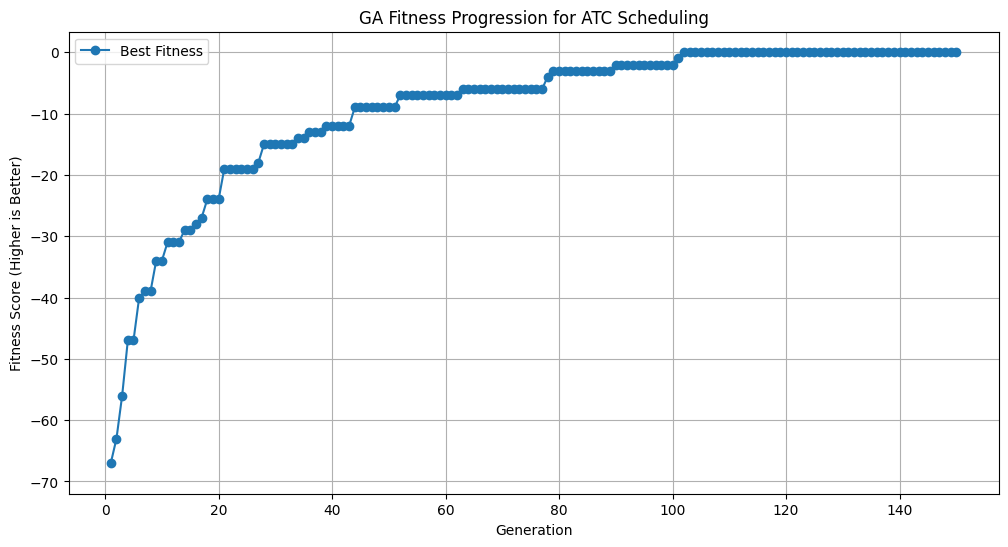

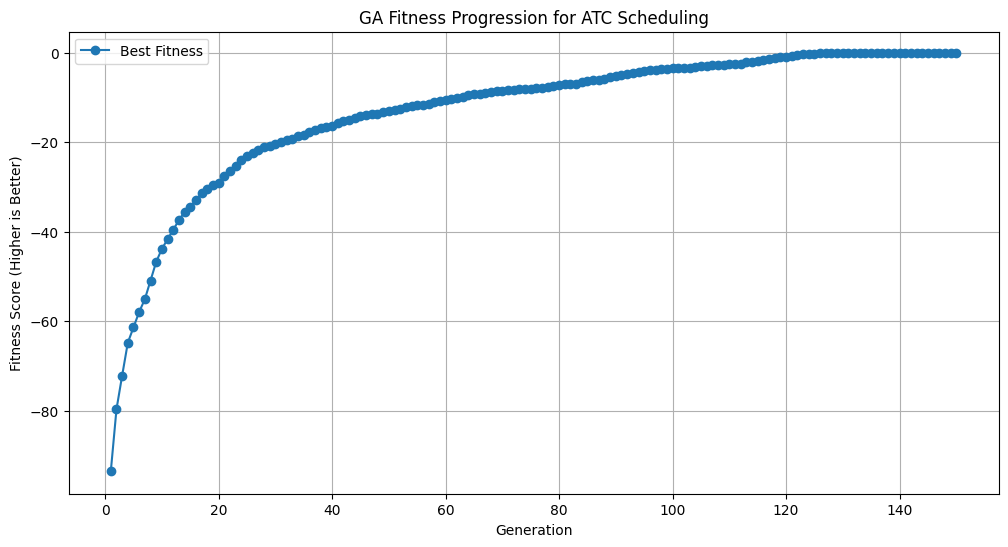

In [43]:
def crossover_3(parent_1, parent_2, num_people, shifts_per_week, crossover_rate):
    """
    Combines parents chromosomes to produce offspring using one point crossover.

    Args:
        parent_1 (list): One parent (schedule) in the crossover
        parent_2 (list): The other parent in the crossover
        num_people (int): Number of people scheduled
        shifts_per_week (int): Number of shifts per week
        crossover_rate (float): Probability that crossover occurs between two parents

    Returns:
        new_parent_1 (list): The new parent resulting from crossover
        new_parent_2 (list): The new parent resulting from crossover
    """
    new_parent_1 = copy.deepcopy(parent_1)
    new_parent_2 = copy.deepcopy(parent_2)
    
    idx = random.choice(range(len(parent_1)))
    temp_p1 = new_parent_1[0:idx]
    new_parent_1[0:idx] = new_parent_2[0:idx]
    new_parent_2[0:idx] = temp_p1 
    
    return new_parent_1, new_parent_2


def genetic_algorithm_3(population_size, num_people, shifts_per_week, shifts_per_day, days_per_week,
                      generations, mutation_rate, crossover_rate):
    """
    Runs a genetic algorithm for a specified number of generations to optimize the schedule

    Args:
    population_size (int): The size that each population is maintained at
    num_people (int): The number of people in the schedule
    shifts_per_week (int): The number of shifts per week
    shifts_per_day (int): The number of shifts per day
    days_per_week (int): The number of days per week 
    generations (int): The number of generations the algorithm will create
    mutation_rate (float): Probability that mutation occurs
    crossover_rate (float): Probability that crossover occurs
    
    Returns:
        best_schedule (list): The best schedule generated
        best_fitness (float): The fitness of the best schedule
        history (list): The best fitness of each generation
        avg_history (list): The average of all fitnesses in each generation
    """
    
    best_schedule = None 
    best_fitness = None
    history = []
    avg_history = []

    # generate the initial population
    population = generate_population(population_size, num_people, shifts_per_week)
    
    for gen in range(generations):
        # find the fitness scores of the current population
        fitness_scores = [evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day) for schedule in population]
        best_fitness_curr = max(fitness_scores)

        # see if best fitness of this gen. is greater than overall best
        if best_fitness is None or best_fitness_curr > best_fitness:
            best_fitness = best_fitness_curr
            best_schedule = copy.deepcopy(population[fitness_scores.index(best_fitness_curr)])
        
        # add this generations best and average fitness to history
        history.append(best_fitness_curr)
        avg_history.append(sum(fitness_scores)/len(fitness_scores))

        # select parents
        parents = parent_selection(population, fitness_scores)

        # crossover
        offspring = []
        for _ in range(population_size // 2):
            parent_1 = random.choice(parents)
            parent_2 = random.choice(parents)
            child1, child2 = crossover_3(parent_1, parent_2, num_people, shifts_per_week, crossover_rate)
            offspring.extend([child1, child2])

        # mutate
        mutated = [mutate(schedule, mutation_rate, num_people, shifts_per_week) for schedule in offspring]

        # select survivors
        population = select_survivors(population, mutated, population_size, num_people, shifts_per_week, shifts_per_day, days_per_week)

    return best_schedule, best_fitness, history, avg_history

# Copy code above to run and plot this function
best_schedule, best_fitness, history, avg_history = genetic_algorithm_3(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
    ) # CHECK THE PARAMETERS!!!

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    # Explain and show the plot
    print("\n" + "="*30)
    print("      Fitness Plot Explanation")
    print("="*30)
    print("The plot shows the fitness score evolution over generations:")
    print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
    print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
    print("Ideally, both lines should trend upwards (towards 0 or positive values).")
    print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history)
plot_fitness(avg_history)